# 🌊 Medical appointment booking with LaVague

This notebook shows how one can use LaVague to create an AI Web Agent that can navigate the web to find out if a doctor is available to book an appointment!

We will automate booking on [Doctolib](https://www.doctolib.fr/), a French leader in medical appointment as an example, but this should work on other websites.

If not, do not hesitate to reach out to us on [Discord](https://discord.com/invite/SDxn9KpqX9) to share your issues.

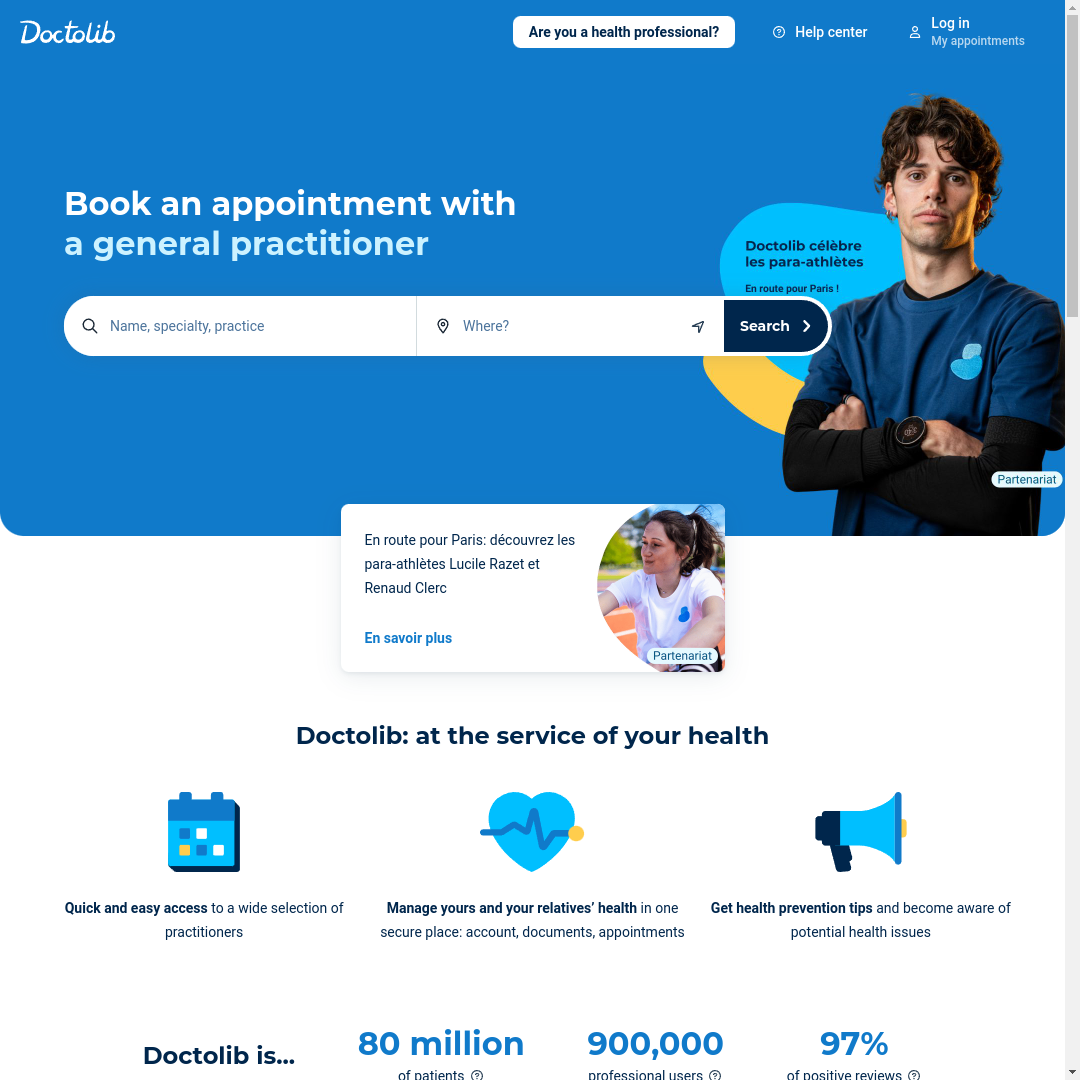

# Overview

We will create the agent and serve it through a [Gradio](https://huggingface.co/papers) interface.

We will use the following solutions to build this AI Web Agent:
- [Claude Sonnet 3.5](https://docs.anthropic.com/en/docs/quickstart) for the [World Model](https://docs.lavague.ai/en/latest/docs/get-started/customization/) to do web planning. You will need to provide an `ANTHROPIC_API_KEY` after getting it. You can look at how to use other models
- [Llama 3.1 70b](https://huggingface.co/meta-llama/Meta-Llama-3.1-70B-Instruct) for the [Action Engine](https://docs.lavague.ai/en/latest/docs/learn/action-engine/) to do action generation to pilot the browser. Here we will use [Fireworks](https://docs.fireworks.ai/getting-started/quickstart) API to consume a managed Llama 3.1 70b. You will therefore need to provide a `FIREWORKS_API_KEY`.
- [OpenAI text-embedding-3-small](https://platform.openai.com/docs/guides/embeddings/embedding-models) to do semantic search on the DOM to find the right element to interact with. This will require an `OPENAI_API_KEY` that you can get following their [quickstart](https://platform.openai.com/docs/quickstart).

If you want to know more about LaVague, you can have a look at our [architecture](https://docs.lavague.ai/en/latest/docs/learn/architecture/), or our [webinars](https://www.youtube.com/watch?v=vBV6s9-_cDs&list=PLzPkw6m0RrnW2SadaswvCAHmyWABOSp8X).

# Installation

We start by downloading LaVague and the other integrations:

In [ ]:
!pip install lavague
!pip install llama-index-multi-modal-llms-anthropic
!pip install llama-index-llms-fireworks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of llama-index-llms-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of llama-index-program-openai to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 70.

We will need to set our secrets with Colab secrets (see the key icon on the left-hand side of the Colab notebook) if on Colab, or simply load them regularly with environment variables.

In [ ]:
import os

# Check if running in Google Colab
try:
    from google.colab import userdata
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    os.environ["FIREWORKS_API_KEY"] = userdata.get('FIREWORKS_API_KEY')
    os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
else:
    os.environ["FIREWORKS_API_KEY"] = os.getenv('FIREWORKS_API_KEY')
    os.environ["ANTHROPIC_API_KEY"] = os.getenv('ANTHROPIC_API_KEY')
    os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Demo

## Agent preparation

We start here by pulling extra knowledge about Doctolib to ensure the `WorldModel` will provide the right reasoning steps.

You can learn more about building Agents with LaVague in our [webinar](https://www.youtube.com/watch?v=bNE4s8h3CIc).

In [ ]:
!wget https://raw.githubusercontent.com/lavague-ai/LaVague/main/examples/knowledge/doctolib_knowledge.txt

--2024-08-04 13:42:31--  https://raw.githubusercontent.com/lavague-ai/LaVague/main/examples/knowledge/doctolib_knowledge.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1619 (1.6K) [text/plain]
Saving to: ‘doctolib_knowledge.txt’

doctolib_knowledge. 100%[===================>]   1.58K  --.-KB/s    in 0s      

2024-08-04 13:42:31 (41.2 MB/s) - ‘doctolib_knowledge.txt’ saved [1619/1619]



We prepare our different integrations then create the Agent:

In [ ]:
from lavague.drivers.selenium import SeleniumDriver
from lavague.core import ActionEngine, WorldModel
from lavague.core.agents import WebAgent

from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal
from llama_index.llms.fireworks import Fireworks
from llama_index.embeddings.openai import OpenAIEmbedding

# Loading the models
mm_lmm = AnthropicMultiModal(model="claude-3-5-sonnet-20240620", max_tokens=512)
llm = Fireworks(model="accounts/fireworks/models/llama-v3p1-70b-instruct", max_tokens=1024)
embedding = OpenAIEmbedding(model="text-embedding-3-small")

# Preparing the Agent
driver = SeleniumDriver(headless=True, no_load_strategy=True)
action_engine = ActionEngine(driver,
                             llm=llm,
                             embedding=embedding,
                             )
world_model = WorldModel(mm_llm=mm_lmm)
world_model.add_knowledge("doctolib_knowledge.txt")

# Create Web Agent
agent = WebAgent(world_model, action_engine, n_steps=15)

# Set URL
agent.get("https://www.doctolib.fr/")

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/legacy/_static/nltk_cache...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/legacy/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/lavague/core/__init__.py:21: UserWarning: Telemetry is turned on. To turn off telemetry, set your LAVAGUE_TELEMETRY to 'NONE'
  warnings.warn(warning_message, UserWarning)
2024-08-04 13:42:43,381 - INFO - Screenshot folder cleared


## Checking the driver is not blocked

It can happen that the driver is blocked.

To check if it is the case, we need to see what is the state of the current page.

Let's display the current screenshot.

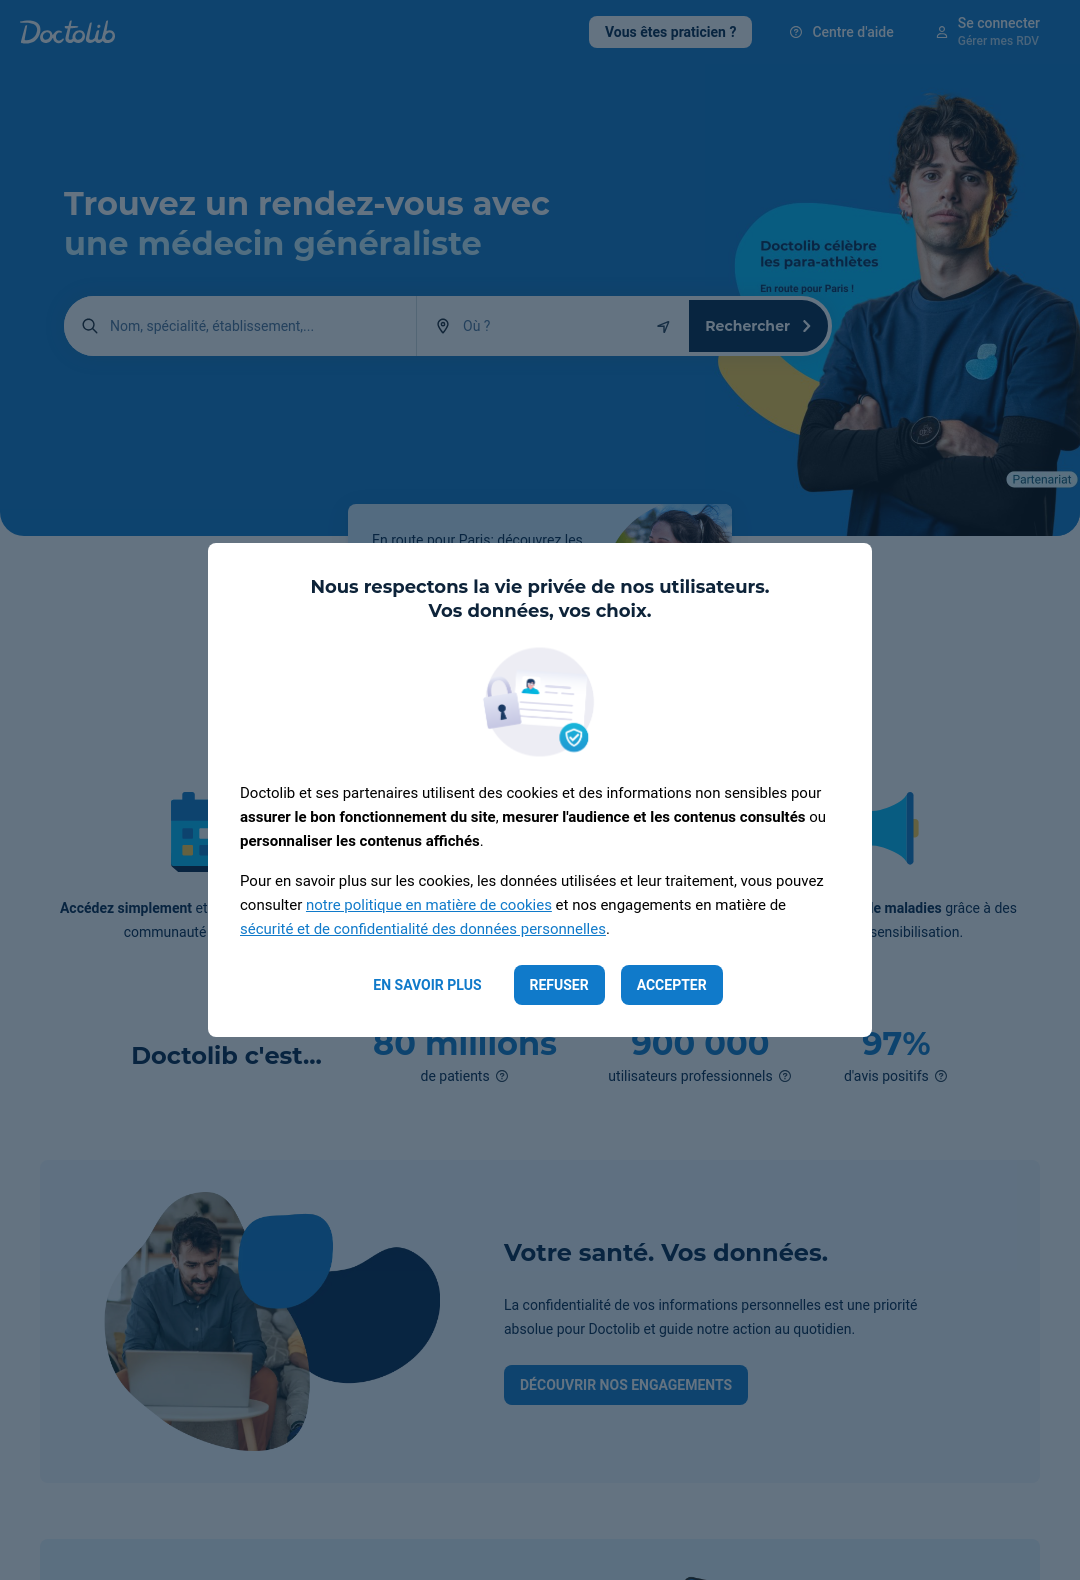

In [ ]:
import time
# We wait to make sure the page is fully loaded
time.sleep(5)

driver.driver.save_screenshot("screenshot.png")
from IPython.display import Image
Image("screenshot.png")

If you see this, you are good to proceed to running the Agent:

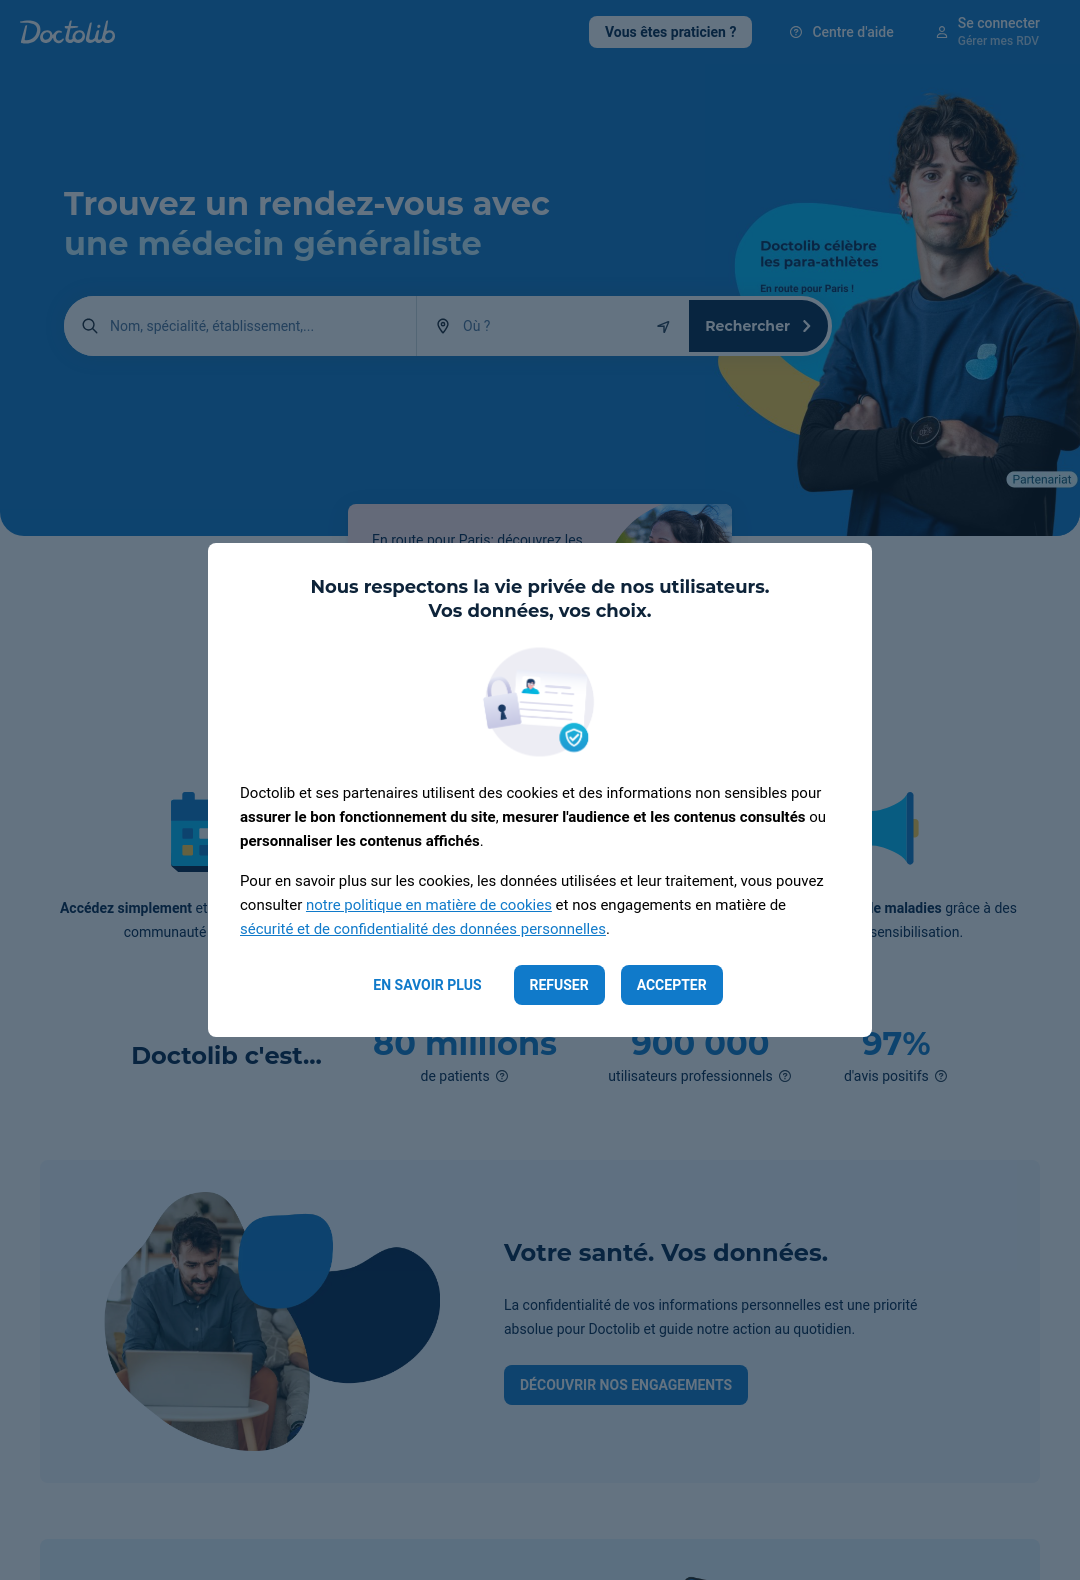

If you see the following screenshot, we will show you ways to avoid unblock the situation:

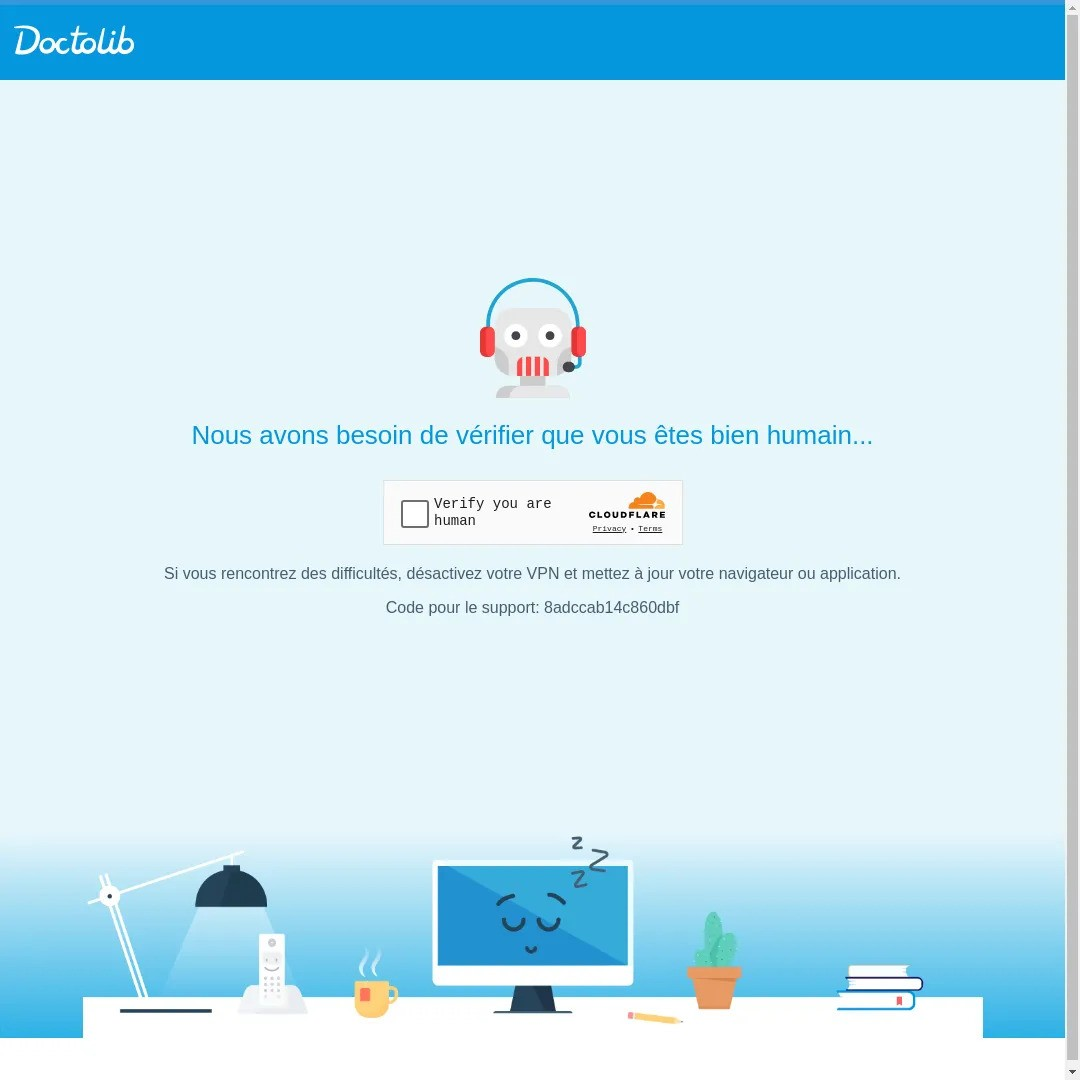

### Unblocking with another Colab Instance

If you are blocked and on Google Colab, just delete the instance and get a new one and see if this one is not blocked.

### Unblocking with Browser Base

If ever you encounter some error showing your browser is being blocked, try using Browser Base with the following code from their [Quick tour](https://docs.browserbase.com/quickstart/selenium) to setup a managed Selenium Driver:

In [ ]:
# from selenium import webdriver
# from selenium.webdriver.remote.remote_connection import RemoteConnection
# from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
# import requests
# import os

# def create_session():
#     url = 'https://www.browserbase.com/v1/sessions'
#     headers = {'Content-Type': 'application/json', 'x-bb-api-key': os.environ["BROWSERBASE_API_KEY"]}
#     response = requests.post(url, json={ "projectId": os.environ["BROWSERBASE_PROJECT_ID"] }, headers=headers)
#     return response.json()['id']

# class CustomRemoteConnection(RemoteConnection):
#     _session_id = None

#     def __init__(self, remote_server_addr: str, session_id: str):
#         super().__init__(remote_server_addr)
#         self._session_id = session_id

#     def get_remote_connection_headers(self, parsed_url, keep_alive=False):
#         headers = super().get_remote_connection_headers(parsed_url, keep_alive)
#         headers.update({'x-bb-api-key': os.environ["BROWSERBASE_API_KEY"]})
#         headers.update({'session-id': self._session_id})
#         return headers

# # Create a new session
# session_id = create_session()

# custom_conn = CustomRemoteConnection('http://connect.browserbase.com/webdriver', session_id)
# options = webdriver.ChromeOptions()
# options.debugger_address = "localhost:9223"

# driver.driver = webdriver.Remote(custom_conn, options=options)

### Unblocking by running with `headless=False`

Another option is to simply run a driver in non-headless mode with:

In [ ]:
driver = SeleniumDriver(headless=True, no_load_strategy=True)

Note that this will not work on Colab, you will have to do it on your own machine.

## Running the Agent

Now we can run the Agent to try booking an appointment for us! We provide the objective below and run it:

In [ ]:
objective = """Accept cookies if they are shown.
Find dermatologists in Paris.
When filling input fields, wait for the results to update before clicking on the most relevant result.
When on the search page, scan the results to find the first dermatologist available in August 2024.
If you find a relevant dermatologist, try to book an appointment in person as a new patient. If not available you can stop here.
Don't use the Python Engine."""

agent.demo(objective=objective)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c7f6c78c04bde0ca83.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
